DR Guia passo a passo para construir um modelo de rede neural profunda com Keras para prever Preços do Airbnb em Nova York e implantação como API REST usando Flask

Este guia permitirá implantar um modelo de aprendizado de máquina começando do zero. Aqui estão as etapas você vai cobrir:

- Defina seu objetivo
- Carregar dados
- Exploração de dados
- Preparação de dados
- Construa e avalie seu modelo
- Salve o modelo
- Construir API REST
- Implantar em produção

### Definir objetivo/meta

Obviamente, você precisa saber por que precisa de um modelo de aprendizado de máquina (ML).Conhecer o objetivo fornece insights sobre:

- O ML é a abordagem certa?
- De quais dados eu preciso?
- Qual será a aparência de um “bom modelo”? Quais métricas posso usar?
- Como resolvo o problema agora? Quão precisa é a solução?
- Quanto custará manter este modelo em funcionamento?

Em nosso exemplo, estamos tentando prever o preço de listagem do Airbnb³² por noite em Nova York. Nosso objetivo é claro - dados alguns dados, queremos que nosso modelo preveja quanto custará alugar um determinado imóvel
por noite.

### Carregar dados

Os dados vêm do Airbnb Open Data e estão hospedados no Kaggle³³

Desde 2008, hóspedes e anfitriões usam o Airbnb para ampliar as possibilidades de viagem e apresentar uma maneira mais única e personalizada de experimentar o mundo. Este conjunto de dados descreve
a atividade de listagem e métricas em NYC, NY para 2019.

#### Configuração 

Começaremos com várias importações e definindo uma semente aleatória para reprodutibilidade:

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import joblib

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 20, 7

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
df = pd.read_csv('airbnb_data\AB_NYC_2019.csv')

In [5]:
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


Como podemos entender do que se tratam nossos dados?

### Data exploration

Esta etapa é crucial. O objetivo é obter uma melhor compreensão dos dados. Você pode ficar tentado
para impulsionar o processo de modelagem, mas isso seria abaixo do ideal. Olhando para grandes quantidades de
Por exemplo, procurar padrões e visualizar distribuições construirá sua intuição sobre os dados.
Essa intuição será útil ao modelar, imputar dados ausentes e observar valores discrepantes.
Uma maneira fácil de começar é contar o número de linhas e colunas em seu conjunto de dados:

In [6]:
df.shape

(48895, 16)

Temos 48.895 linhas e 16 colunas. Dados suficientes para fazer algo interessante. Vamos começar com a variável que estamos tentando prever o preço. Para traçar a distribuição, usaremos

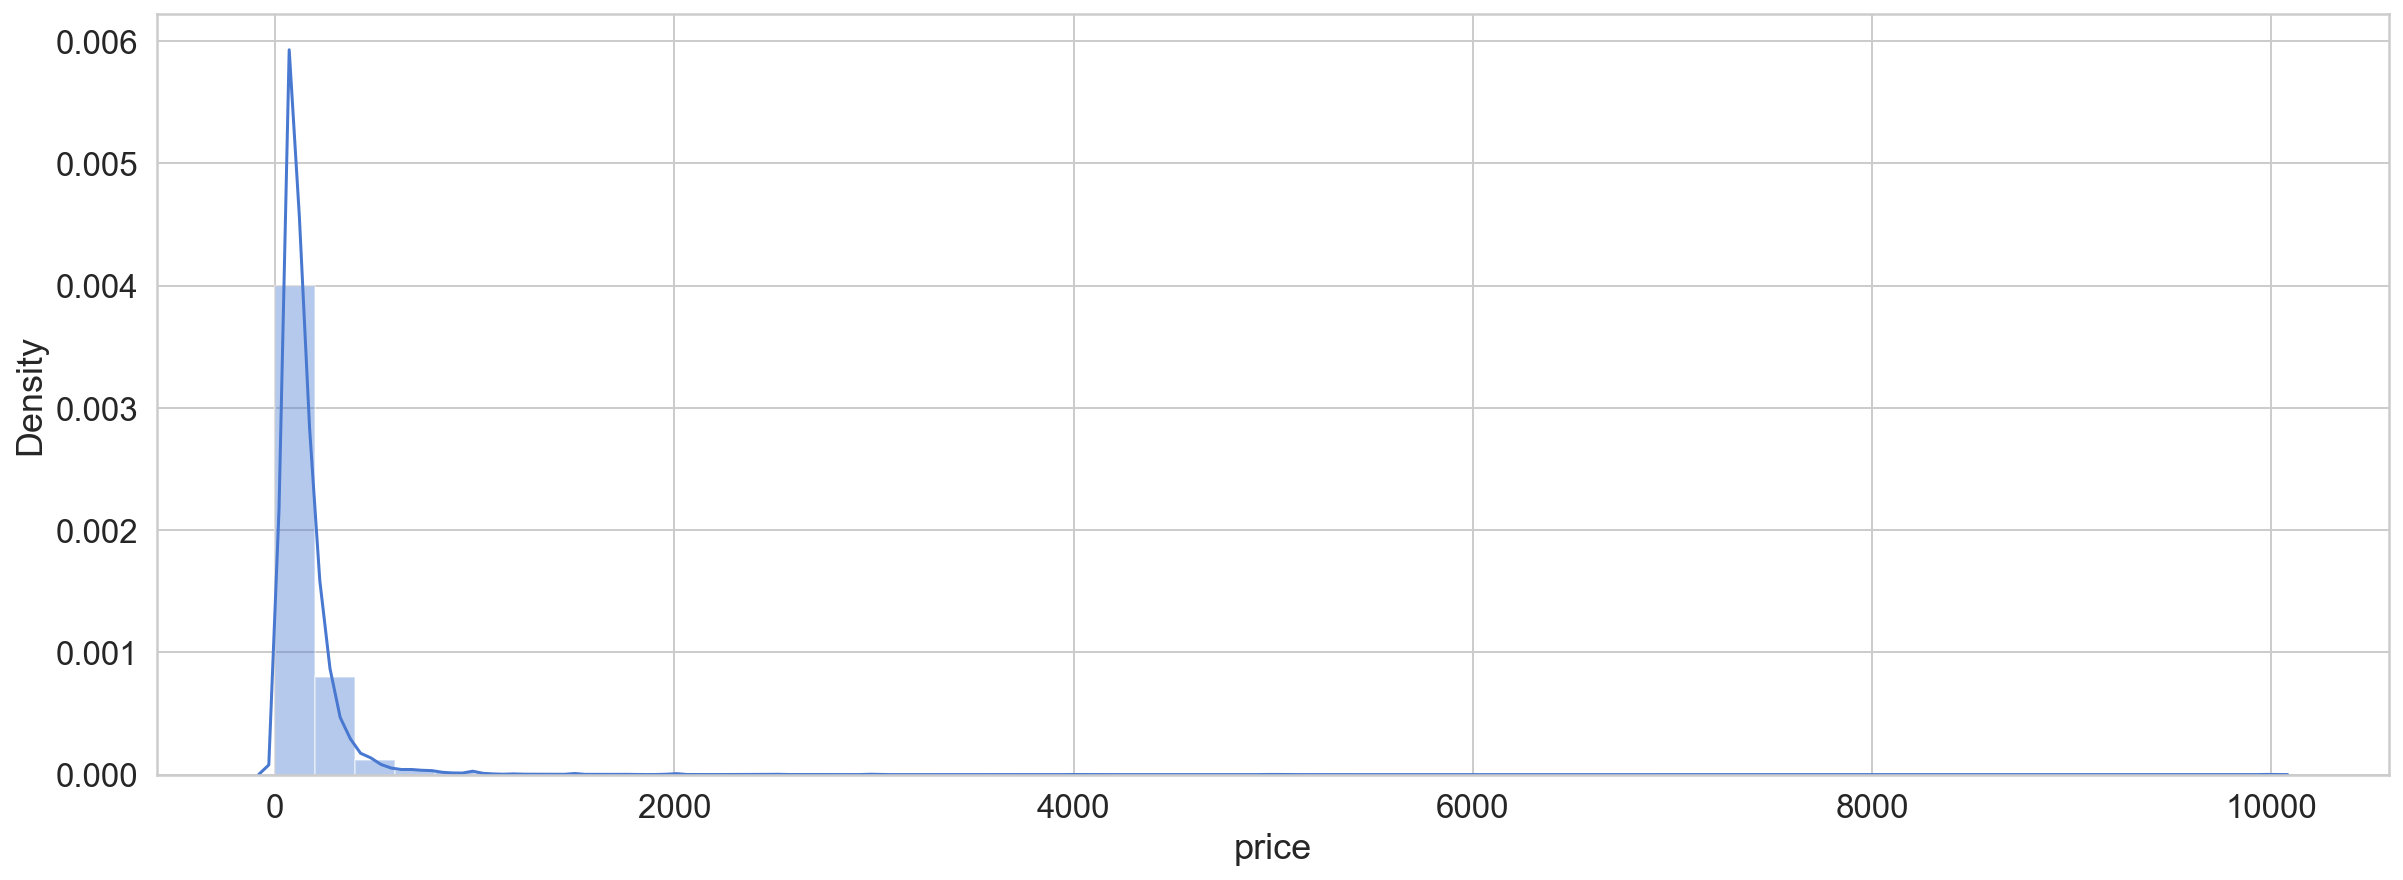

In [7]:
sns.distplot(df.price);

Temos uma distribuição altamente distorcida com alguns valores na faixa de 10.000 (você pode querer explore-os). Usaremos um truque - transformação de log:

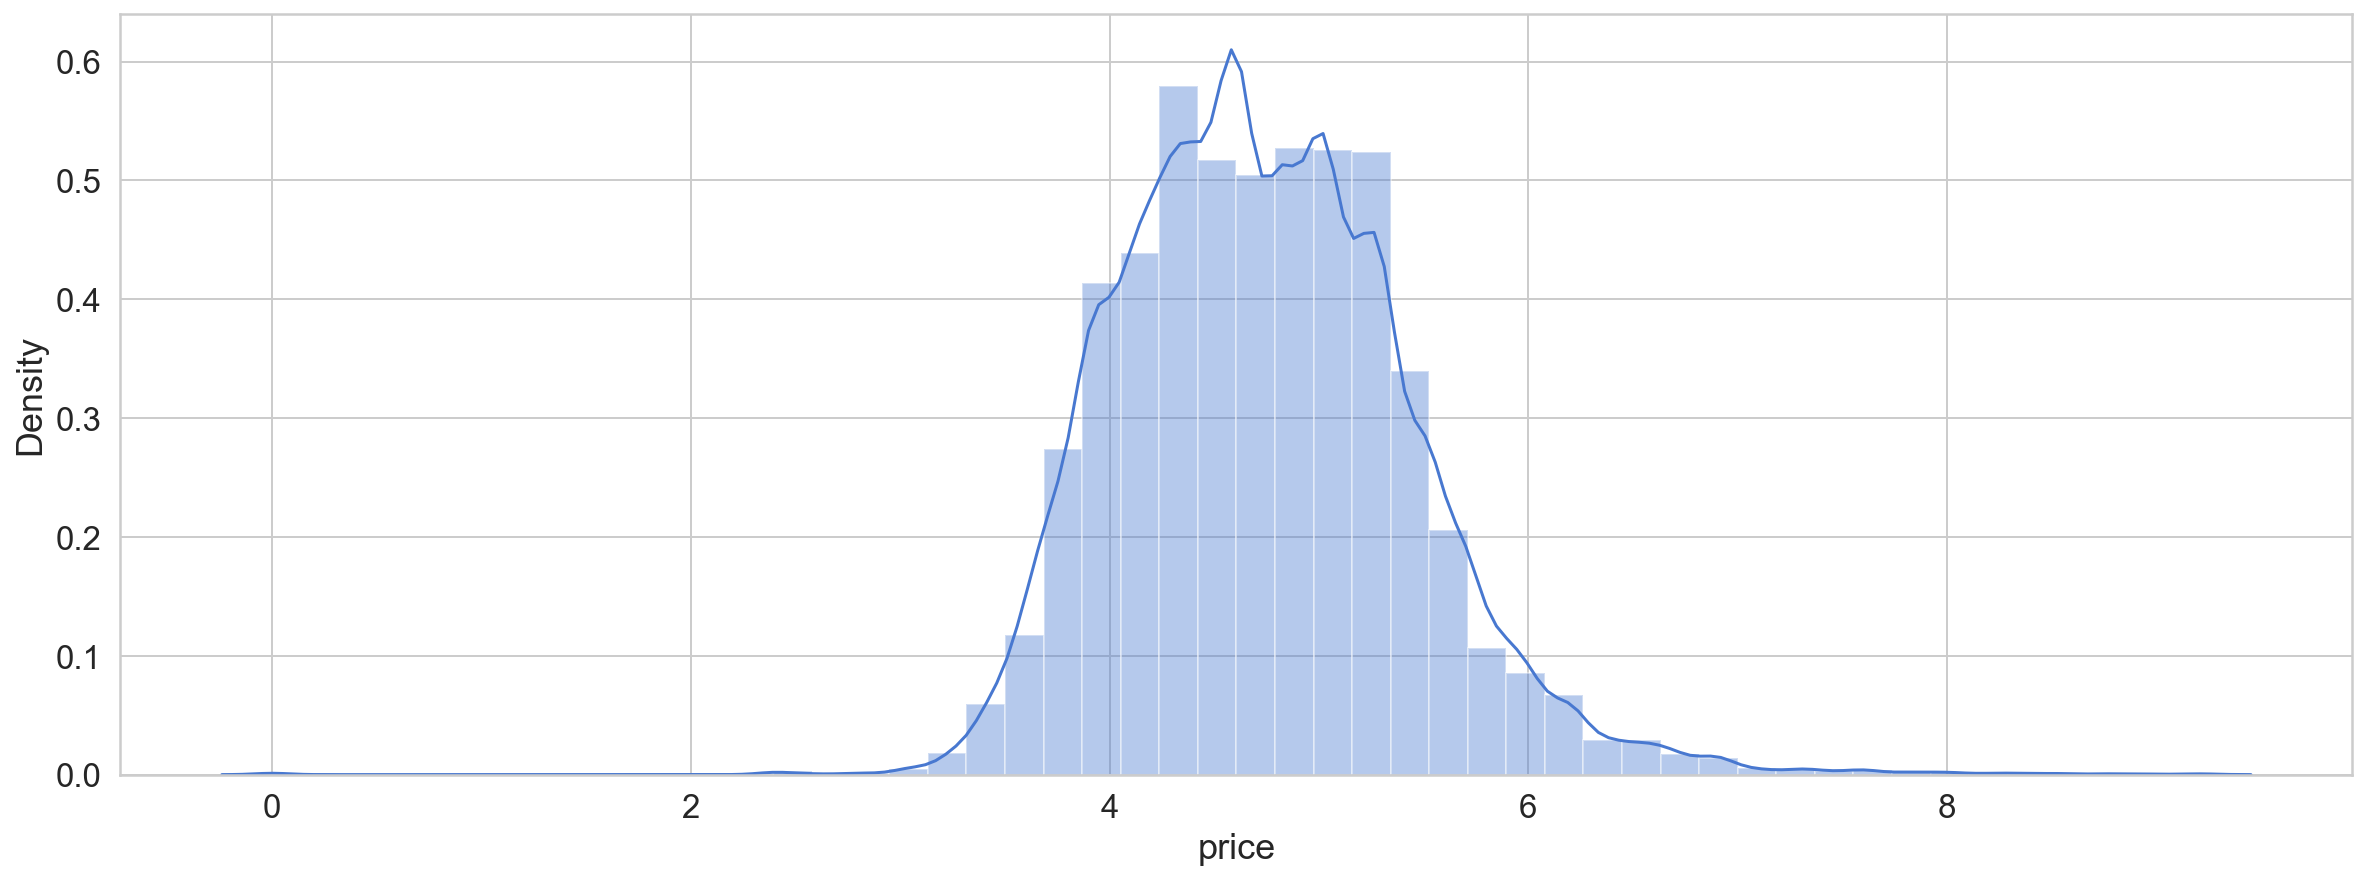

In [8]:
sns.distplot(np.log1p(df.price));

Isso se parece mais com uma distribuição normal. Acontece que isso pode ajudar seu modelo a aprender melhor o dados³⁴. Você terá que se lembrar de pré-processar os dados antes de treinar e prever. O tipo de quarto parece ser outro ponto interessante. Vamos dar uma olhada:

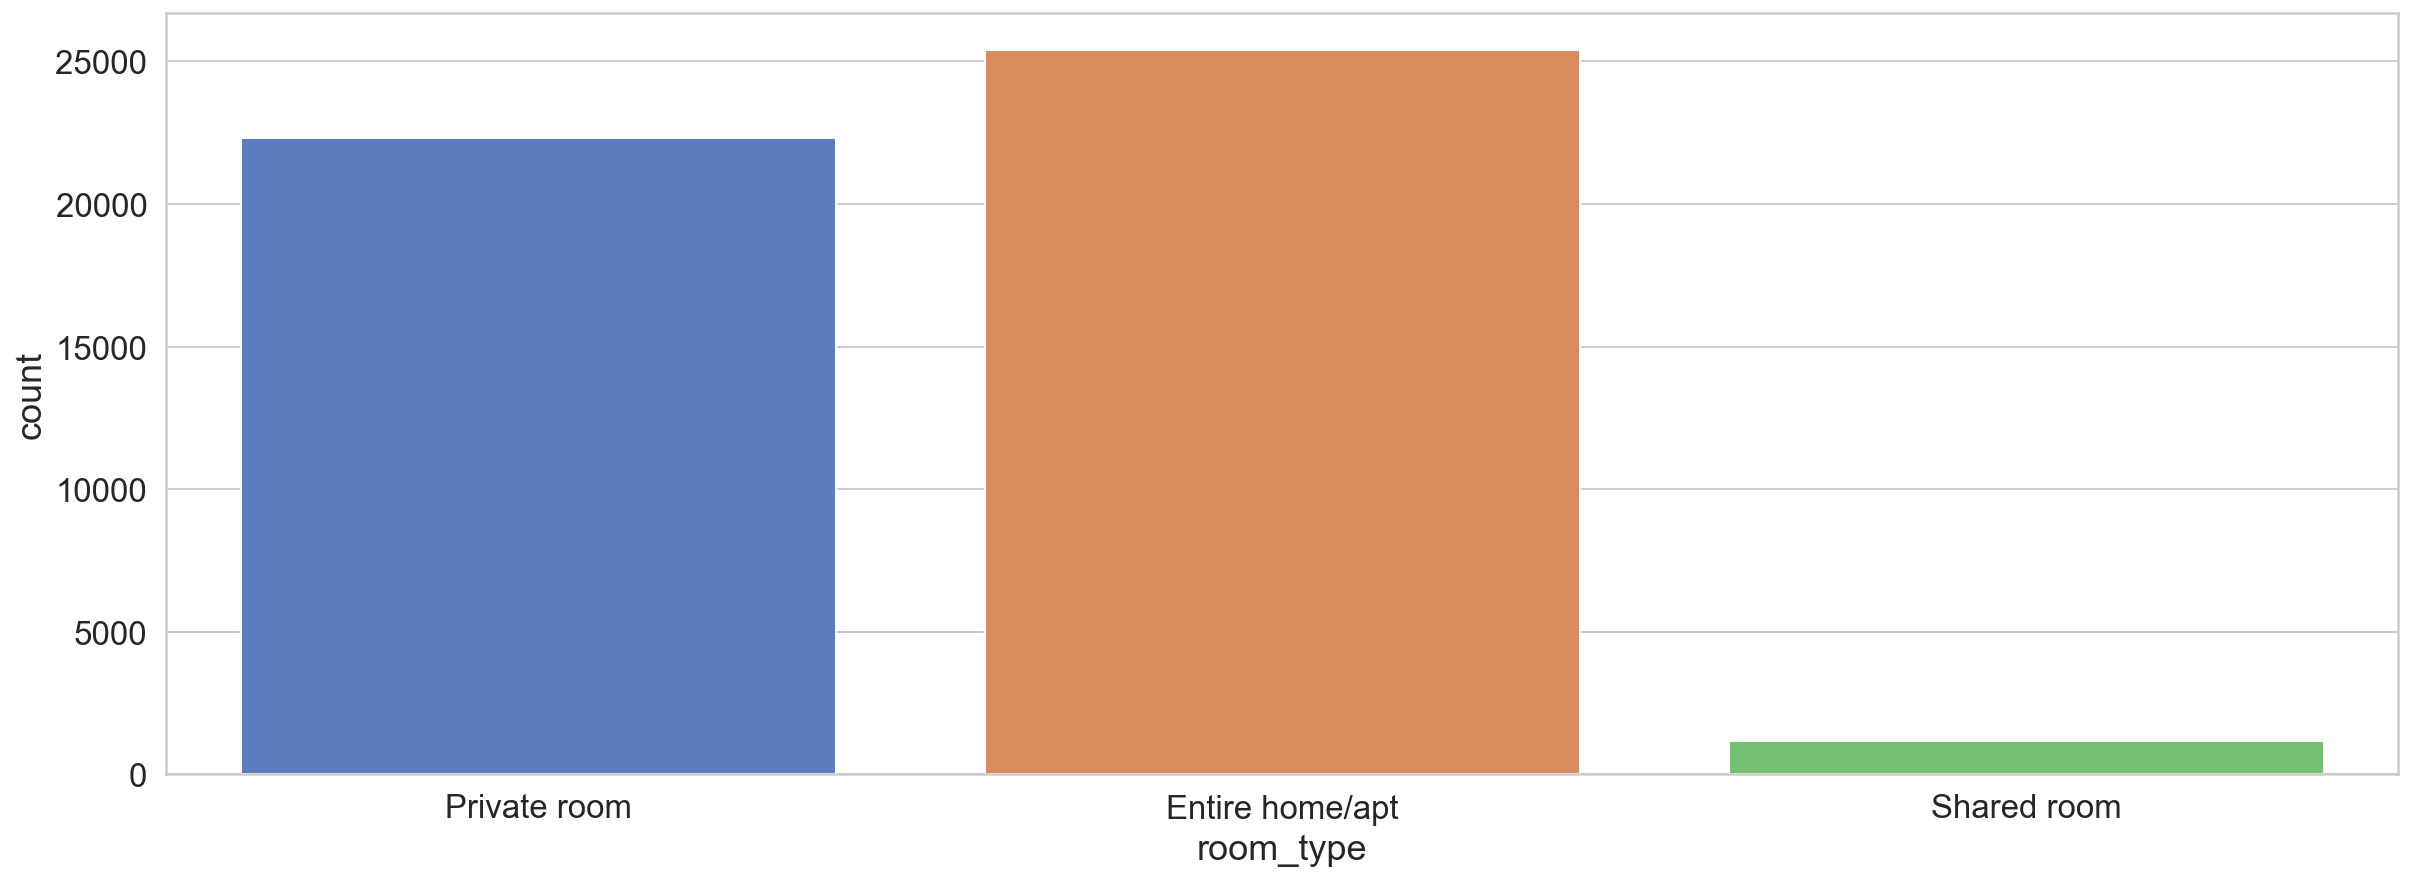

In [9]:
sns.countplot(x='room_type', data=df);

A maioria das listagens oferece lugares inteiros ou quartos privados. E quanto à localização? Que bairro grupos estão mais representados?

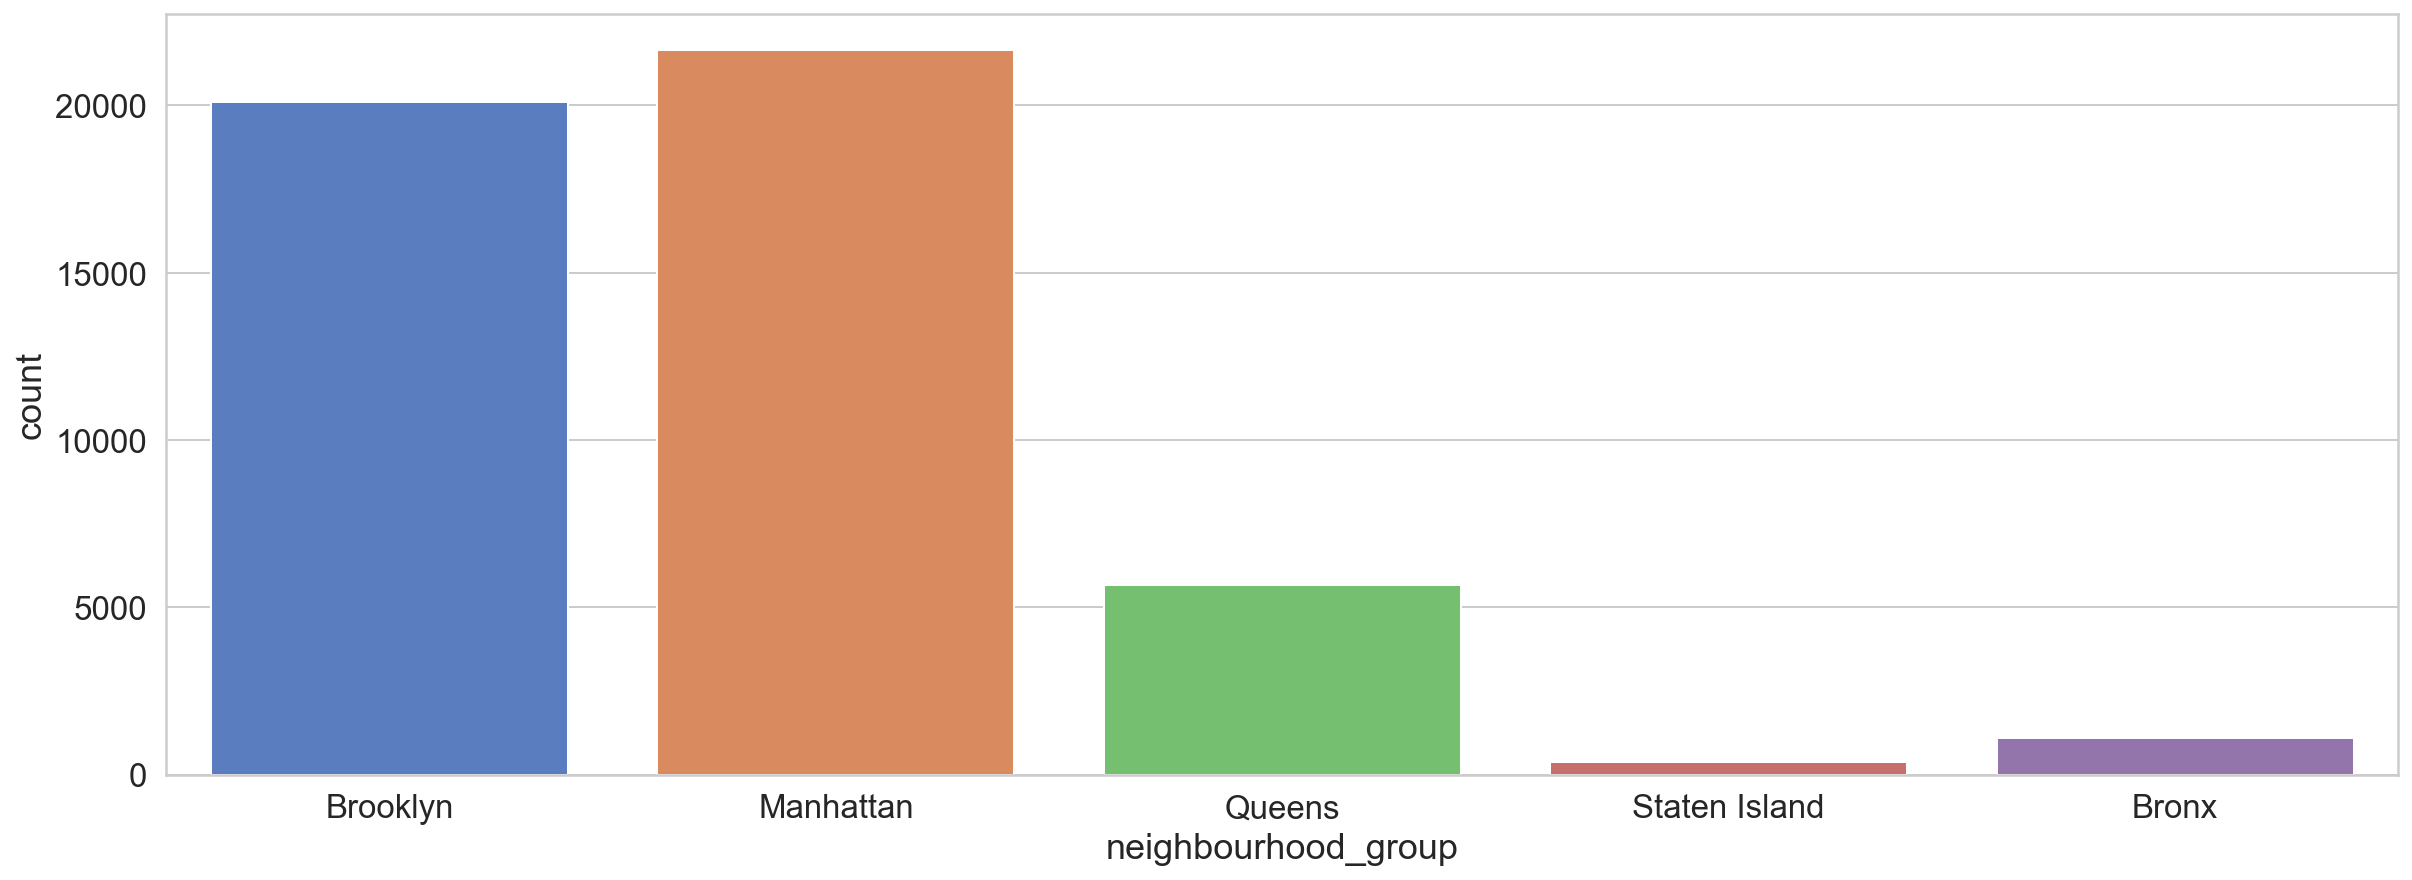

In [10]:
sns.countplot(x='neighbourhood_group', data=df);

Como esperado, Manhattan lidera. Obviamente, o Brooklyn também está muito bem representado. Você pode
obrigado Mos Def, Nas, Masta Ace e Fabolous por isso.
Outra característica interessante é o número de avaliações. Vamos dar uma olhada nisso:

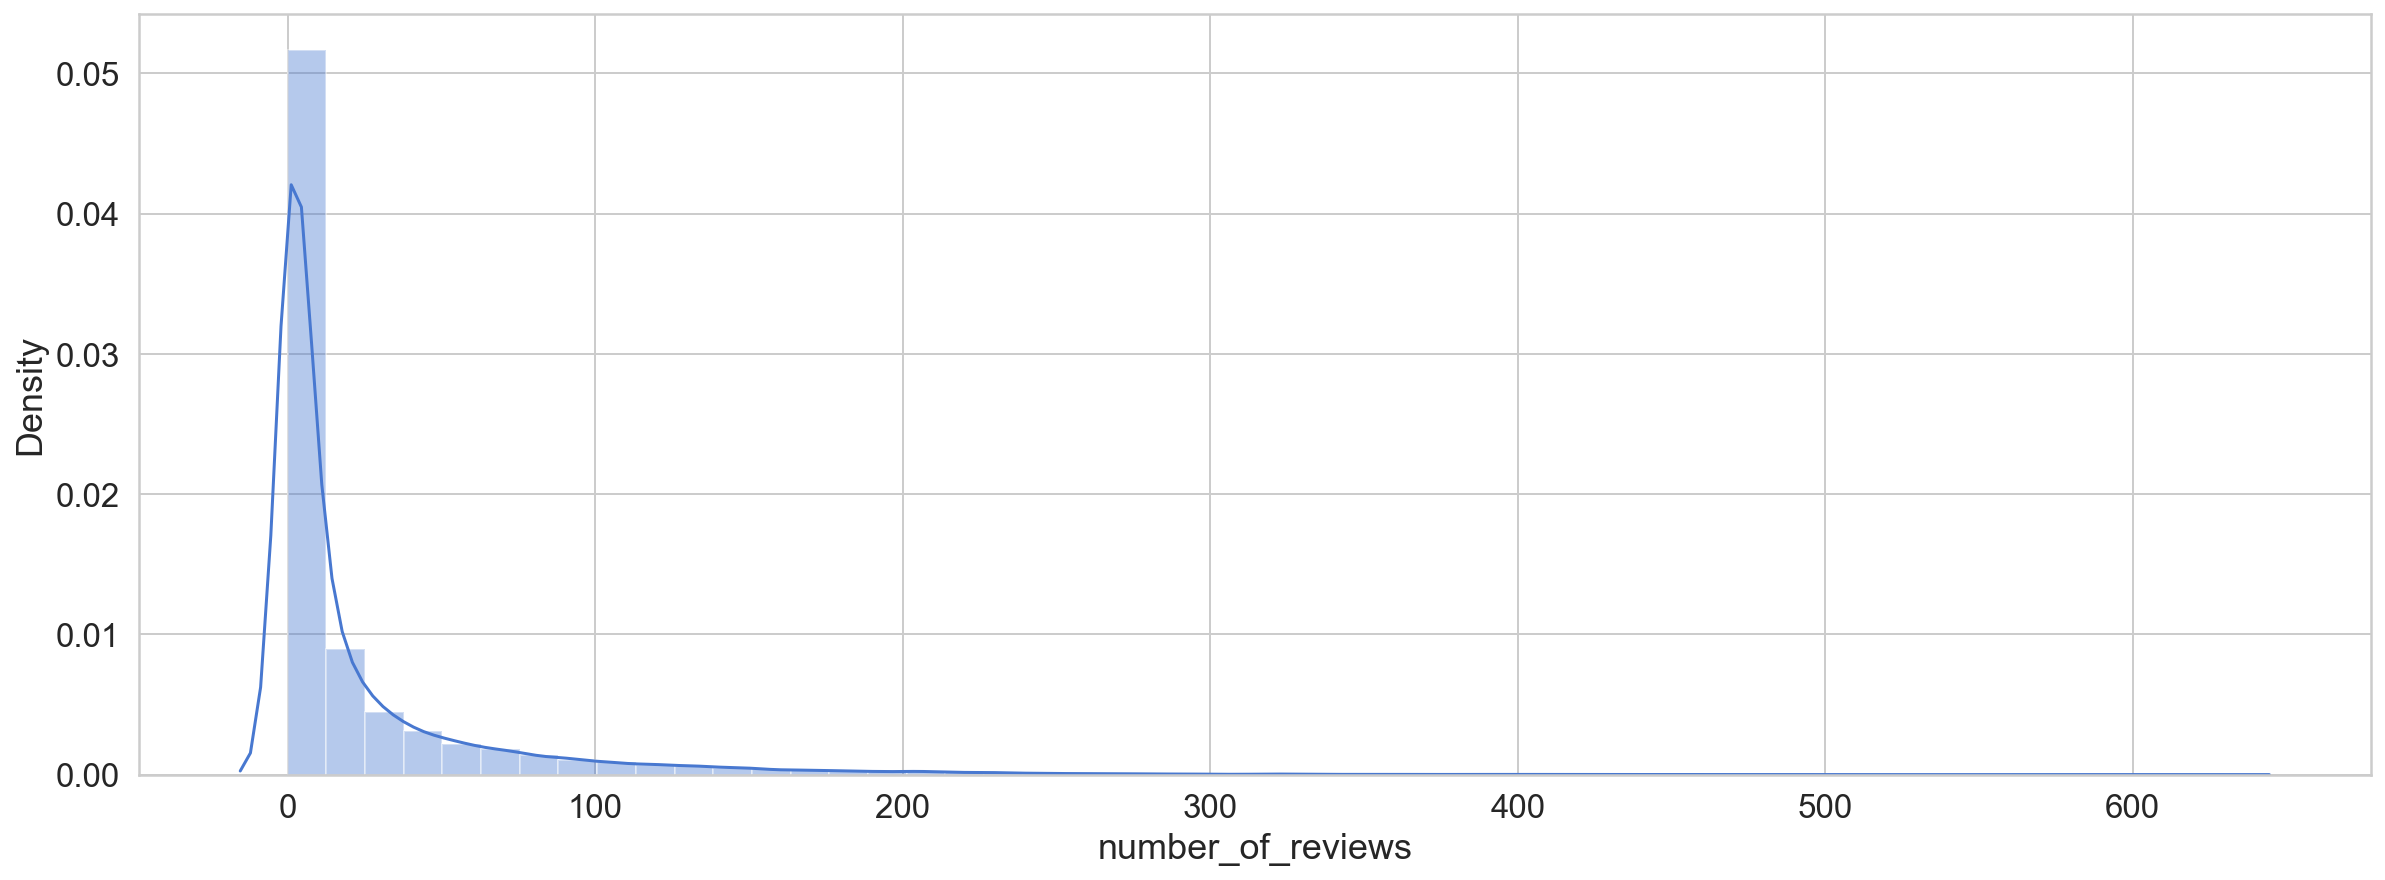

In [11]:
sns.distplot(df.number_of_reviews);

Este parece seguir uma lei de potência³⁵ (tem cauda gorda). Este parece seguir uma lei de potência³⁶ (é tem uma cauda gorda). Parece haver alguns valores discrepantes (à direita) que podem ser de interesse para investigação.

#### Encontrando Correlações

A análise de correlação pode fornecer dicas sobre quais recursos podem ter poder preditivo quando treinando seu modelo.

Lembre-se, correlação não implica causalidade³⁷

Calcular o coeficiente de correlação de Pearson³⁸ entre um par de recursos é fácil:

In [12]:
corr_matrix = df.corr();

Vejamos a correlação do preço com os demais atributos:

In [13]:
price_corr = corr_matrix['price']
price_corr.iloc[price_corr.abs().argsort()]

id                                0.010619
host_id                           0.015309
reviews_per_month                -0.030608
latitude                          0.033939
minimum_nights                    0.042799
number_of_reviews                -0.047954
calculated_host_listings_count    0.057472
availability_365                  0.081829
longitude                        -0.150019
price                             1.000000
Name: price, dtype: float64

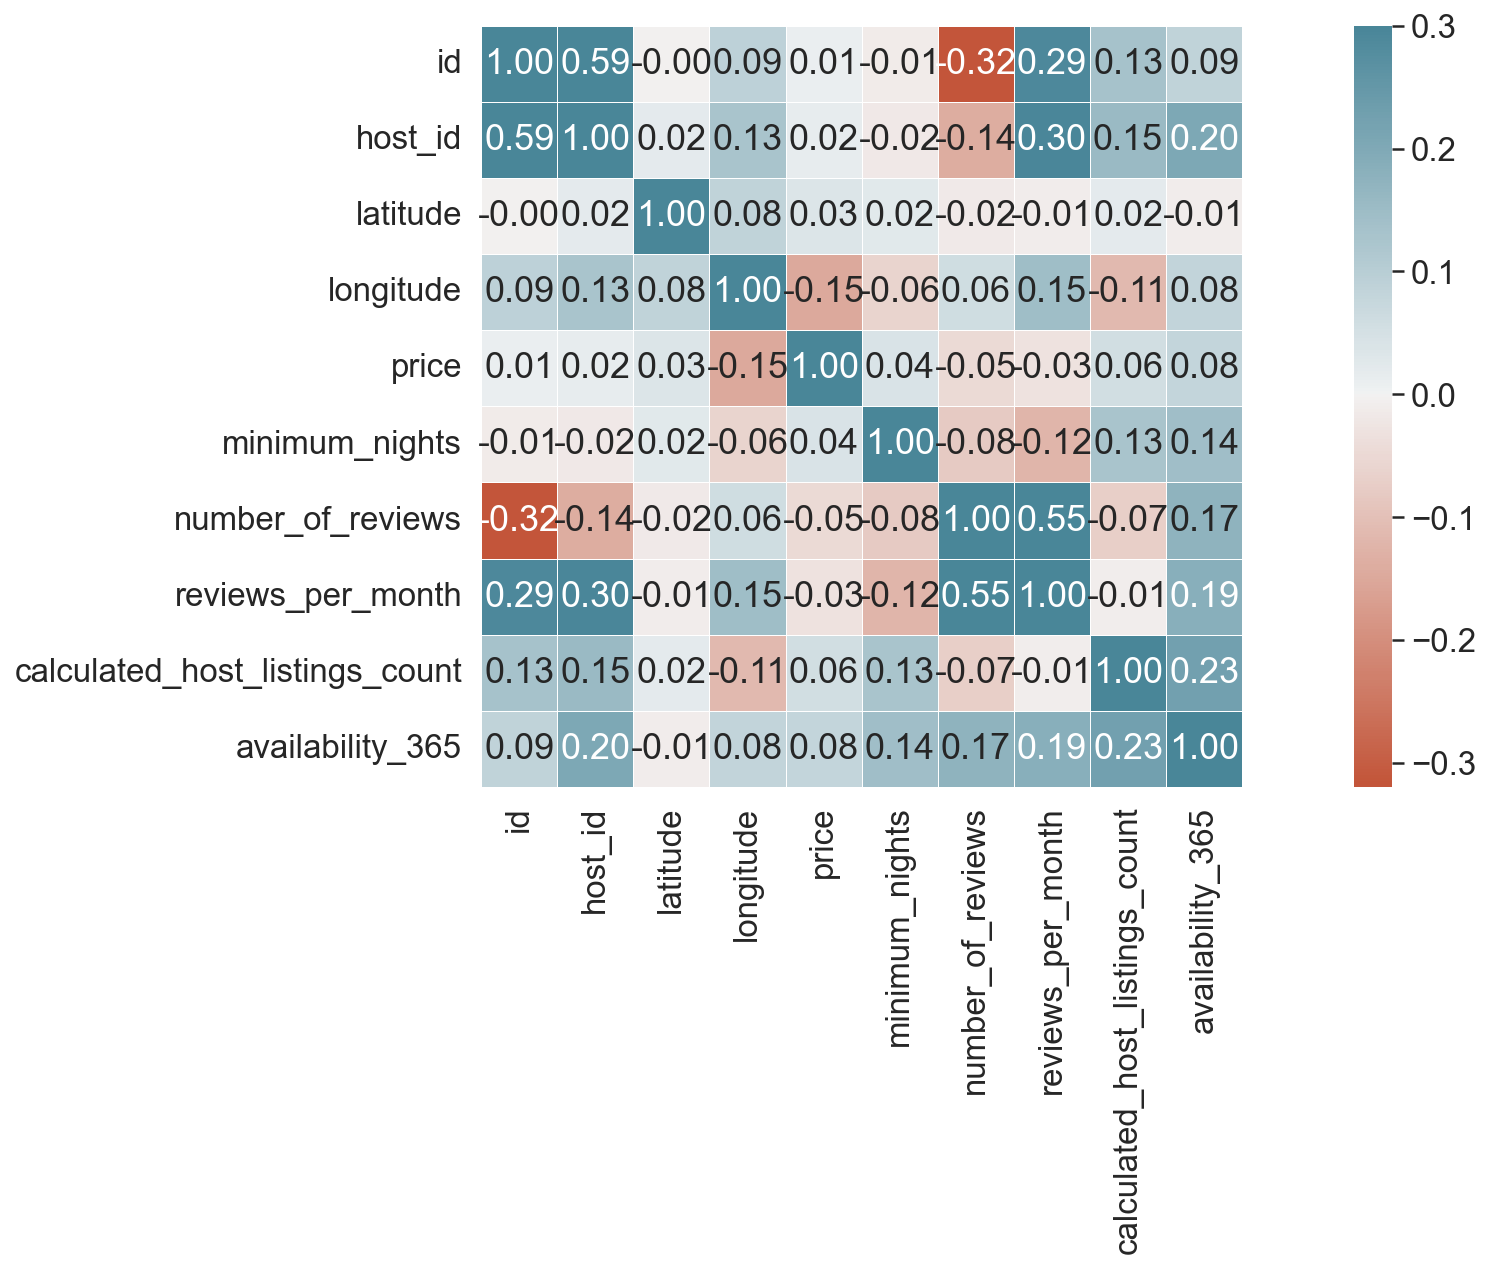

In [14]:
palette = sns.diverging_palette(20, 220, n=256)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5);

O coeficiente de correlação é definido no intervalo de -1 a 1. Um valor próximo de 0 significa que não há correlação. O valor 1 sugere uma correlação positiva perfeita (por exemplo, à medida que o preço do Bitcoin aumenta, seus sonhos de possuir mais também estão aumentando!). O valor de -1 sugere correlação negativa perfeita (por exemplo, um grande número de críticas negativas deve estar correlacionado com preços mais baixos).

A correlação em nosso conjunto de dados parece muito ruim. Felizmente, os recursos categóricos não estão incluídos aqui. Eles também podem ter algum poder preditivo! Como podemos usá-los?

### Prepare os dados

O objetivo aqui é transformar os dados em um formato adequado ao seu modelo. Existem vários coisas que você deseja fazer ao lidar com dados estruturados (pense em CSV, banco de dados):

- Lidar com dados ausentes
- Remova colunas desnecessárias
- Transformar quaisquer recursos categóricos em números/vetores
- Dimensionar recursos numéricos

#### Dados ausentes

Vamos começar com uma verificação de dados ausentes:

In [15]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

last_review          10052
reviews_per_month    10052
host_name               21
name                    16
dtype: int64

Iremos apenas prosseguir e remover esses recursos neste exemplo. Em aplicações do mundo real, você deveria considerar outras abordagens.

In [16]:
df = df.drop(['id', 'name', 'host_id', 'host_name',
              'reviews_per_month', 'last_review', 'neighbourhood'
              ], axis=1)

In [17]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [18]:
df.columns

Index(['neighbourhood_group', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

Também estamos eliminando a vizinhança, o ID do host (muitos valores exclusivos) e o ID da listagem.
A seguir, estamos dividindo os dados em recursos que usaremos para a previsão e uma variável de destino
e (o preço):

In [19]:
X = df.drop('price', axis=1)
y = np.log1p(df.price.values)

Observe que estamos aplicando a transformação logarítmica ao preço.

#### Dimensionamento de recursos e dados categóricos

Vamos começar com o escalonamento de recursos³⁹. Especificamente, faremos a normalização min-max e dimensionaremos os recursos
na faixa 0-1. Felizmente, o MinMaxScaler⁴⁰ do scikit-learn faz exatamente isso.

Mas por que dimensionar recursos? Em grande parte por causa do algoritmo que usaremos para treinar nossos
modelo⁴¹ se sairá melhor com isso.

Em seguida, precisamos pré-processar os dados categóricos. Por que?

Alguns algoritmos de aprendizado de máquina podem operar em dados categóricos sem qualquer pré-processamento (como
Árvores de decisão, Naive Bayes). Mas a maioria não consegue.

Infelizmente, você não pode substituir os nomes das categorias por um número. Convertendo Brooklyn para 1 e Manhattan para 2 sugere que Manhattan é maior (2 vezes) que Brooklyn. Isso não faz sentido.

Como podemos resolver isso?

Podemos usar codificação One-hot⁴². Para ter uma ideia do que ele faz, usaremos OneHotEncoder⁴³ de
scikit-aprender:

In [20]:
from sklearn.preprocessing import OneHotEncoder

In [21]:
data = [['Manhattan'], ['Brooklyn']]
OneHotEncoder(sparse=False).fit_transform(data)

array([[0., 1.],
       [1., 0.]])

Essencialmente, você obtém um vetor para cada valor que contém 1 no índice da categoria e 0 para
todos os outros valores. Essa codificação resolve o problema de comparação. A parte negativa é que seus dados
agora pode ocupar muito mais memória.

Todas as etapas de pré-processamento de dados devem ser executadas nos dados de treinamento e nos dados que receberemos
por meio da API REST para previsão. Podemos unir as etapas usando make_column_transformer()⁴⁴:

In [22]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

In [23]:
transformer = make_column_transformer((MinMaxScaler(),
                                       ['latitude',
                                        'longitude', 
                                        'minimum_nights',
                                        'number_of_reviews', 
                                        'calculated_host_listings_count',
                                        'availability_365']),
                                      (OneHotEncoder(handle_unknown="ignore"), 
                                       ['neighbourhood_group', 'room_type']))

Enumeramos todas as colunas que precisam de escalonamento de recursos e codificação one-hot. Essas colunas serão
substituídos pelos das etapas de pré-processamento. A seguir, aprenderemos os intervalos e categorias
mapeamento usando nosso transformador:

In [24]:
transformer.fit(X)

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['latitude', 'longitude', 'minimum_nights',
                                  'number_of_reviews',
                                  'calculated_host_listings_count',
                                  'availability_365']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['neighbourhood_group', 'room_type'])])

Por fim, transformaremos nossos dados:

In [25]:
X = transformer.transform(X)

In [26]:
X

array([[0.35739347, 0.51192067, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.61419895, 0.49046911, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.74825175, 0.56925653, 0.00160128, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.76211678, 0.55651732, 0.00720576, ..., 1.        , 0.        ,
        0.        ],
       [0.62361168, 0.4766385 , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.63941249, 0.48000677, 0.00480384, ..., 0.        , 1.        ,
        0.        ]])

A última coisa é separar os dados em conjuntos de treinamento e teste:

In [27]:
X_train, X_test, y_train, y_test =\
train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [28]:
X_train

array([[5.22612336e-01, 5.44041548e-01, 1.60128102e-03, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.45403731e-01, 5.71928570e-01, 8.00640512e-04, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [4.60086626e-01, 5.36194795e-01, 8.00640512e-04, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [6.85726039e-01, 5.09380351e-01, 2.32185749e-02, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.66126261e-01, 4.97751350e-01, 8.00640512e-04, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.97139884e-01, 5.62388273e-01, 3.20256205e-03, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

Você usará apenas o conjunto de treinamento ao desenvolver e avaliar seu modelo. O conjunto de teste
será usado mais tarde.
É isso! Agora você está pronto para construir um modelo. Como você pode fazer isso?

### Construa seu modelo

Finalmente, é hora de fazer algumas modelagens. Lembre-se da meta que estabelecemos para nós mesmos no início:

Estamos tentando prever o preço do anúncio do Airbnb⁴⁵ por noite em Nova York
Temos um problema de previsão de preços em mãos. De modo mais geral, estamos tentando prever um número

valor definido em uma faixa muito grande. Isso se encaixa perfeitamente na estrutura de Análise de Regressão⁴⁶.

Treinar um modelo se resume a minimizar alguns erros predefinidos. Que erro devemos medir?

#### Medição de erros

Usaremos o erro quadrático médio⁴⁷, que mede a diferença entre a média quadrada prevista
e valores verdadeiros:

![MSE](img/MSE.png)


onde $n$ é o número de amostras, $Y$ é um vetor contendo os valores reais e $\hat{Y}$ é um vetor contendo as previsões do nosso modelo.
Agora que você tem uma medida do desempenho do seu modelo, é hora de construí-lo em si. Como você pode construir uma rede neural profunda com Keras?

#### Construa uma rede neural profunda com Keras

Keras⁴⁸ é a API oficial de alto nível do TensorFlow⁴⁹. Resumindo, permite construir modelos complexos
usando uma interface agradável. Vamos construir um modelo com ele:

In [50]:
model = keras.Sequential()
model.add(keras.layers.Dense(units=64, activation="relu", input_shape=[X_train.shape[1]]))
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(units=32, activation="relu"))
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(1))

A API sequencial permite adicionar facilmente várias camadas ao seu modelo. Observe que especificamos
o input_size na primeira camada usando os dados de treinamento. Também fazemos regularização usando Dropout
camadas⁵⁰.
Como podemos especificar a métrica de erro?

In [51]:
model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss = 'mse', 
    metrics = ['mse'])

O método compile()⁵¹ permite especificar o otimizador e a métrica de erro que você precisa reduzir.
Seu modelo está pronto para treinamento. Vamos!
Treinamento
Treinar um modelo Keras envolve chamar um único método - fit()⁵²:

In [52]:
BATCH_SIZE = 32

early_stop = keras.callbacks.EarlyStopping(
  monitor='val_mse',
  mode="min",
  patience=10
)

history = model.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=100,
  validation_split=0.2,
  batch_size=BATCH_SIZE,
  callbacks=[early_stop]
)

Epoch 1/100


978/978 [==============================] - 3s 2ms/step - loss: 7.4406 - mse: 7.4406 - val_loss: 0.5172 - val_mse: 0.5172
Epoch 2/100
978/978 [==============================] - 2s 2ms/step - loss: 2.2847 - mse: 2.2847 - val_loss: 0.4473 - val_mse: 0.4473
Epoch 3/100
978/978 [==============================] - 2s 2ms/step - loss: 2.0664 - mse: 2.0664 - val_loss: 0.4136 - val_mse: 0.4136
Epoch 4/100
978/978 [==============================] - 3s 3ms/step - loss: 1.9243 - mse: 1.9243 - val_loss: 0.4211 - val_mse: 0.4211
Epoch 5/100
978/978 [==============================] - 3s 3ms/step - loss: 1.8099 - mse: 1.8099 - val_loss: 0.4106 - val_mse: 0.4106
Epoch 6/100
978/978 [==============================] - 2s 3ms/step - loss: 1.7210 - mse: 1.7210 - val_loss: 0.3889 - val_mse: 0.3889
Epoch 7/100
978/978 [==============================] - 2s 2ms/step - loss: 1.5946 - mse: 1.5946 - val_loss: 0.4017 - val_mse: 0.4017
Epoch 8/100
978/978 [==============================] - 3s 3ms/step - loss: 1.5216

Alimentamos o método de treinamento com os dados de treinamento e especificamos os seguintes parâmetros:

- shuffle - ordena aleatoriamente os dados
- épocas - número de ciclos de treinamento
- validação_split - use alguma porcentagem dos dados para medir o erro e não durante o treinamento
- batch_size - o número de exemplos de treinamento que são alimentados de cada vez em nosso modelo
- retornos de chamada - usamos EarlyStopping⁵³ para evitar que nosso modelo se ajuste demais durante o treinamento e o erro de validação começa a divergir

Após a conclusão do longo processo de treinamento, você precisa responder a uma pergunta. Seu modelo pode fazer
boas previsões?

### Evaluation

Uma maneira simples de entender o processo de treinamento é observar a perda de treinamento e validação:

In [53]:
def plot_mse(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.plot(hist['epoch'], hist['mse'],
            label='Train MSE')
  plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val MSE')
  plt.legend()
  plt.show()

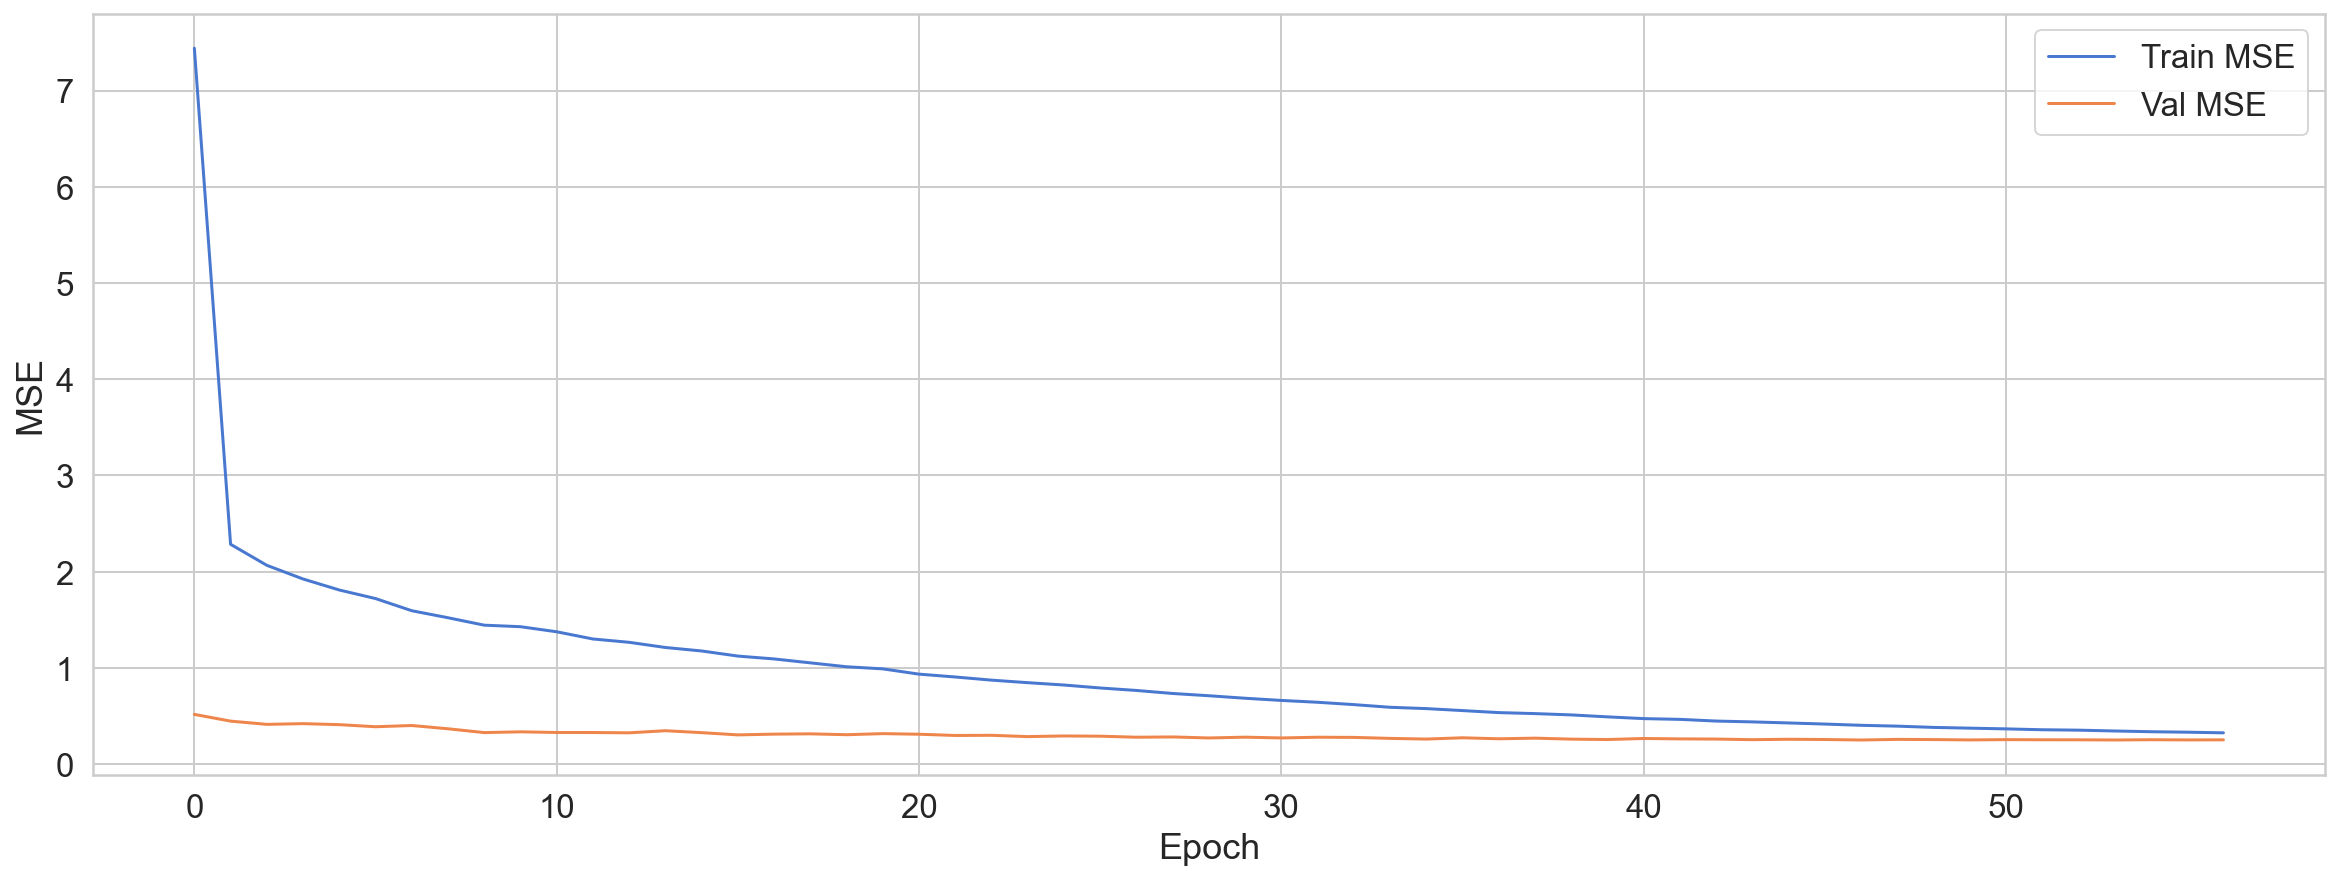

In [54]:
plot_mse(history)

Podemos ver uma grande melhoria no erro de treinamento, mas não muito no erro de validação. O que mais podemos usar para testar nosso modelo?

#### Usando os dados de teste

Lembre-se de que temos alguns dados adicionais. Agora é hora de usá-lo e testar a qualidade do nosso modelo. Observação
que não utilizamos esses dados durante o treinamento, apenas uma vez no final do processo.

Vamos obter as previsões do modelo:

In [56]:
y_pred = model.predict(X_test)

306/306 [==============================] - 0s 984us/step


E usaremos algumas métricas para a avaliação:

In [57]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

print(f'MSE {mean_squared_error(y_test, y_pred)}')
print(f'RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}')

MSE 0.22839935425356603
RMSE 0.4779114502222834


Já discutimos o MSE. Você provavelmente pode adivinhar o que é Root Mean Squared Error (RMSE)⁵⁴
significa. O RMSE nos permite penalizar pontos mais distantes da média.
Outra estatística que podemos usar para medir o quão bem nossas previsões se ajustam aos dados reais é $R^2$
pontuação⁵⁵. Um valor próximo de 1 indica um ajuste perfeito. Vamos verificar o nosso:

In [58]:
print(f'R2 {r2_score(y_test, y_pred)}')

R2 0.5172155927796673


Definitivamente há espaço para melhorias aqui. Você pode tentar ajustar melhor o modelo e melhorar
resultados.
Agora você tem um modelo e uma ideia aproximada de quão bem ele se sairá na produção. Como você pode economizar
seu trabalho?

### Salve o modelo

In [ ]:
import joblib

joblib.dump(transformer, "models/data_transformer.joblib")
model.save("models/price_prediction_model.h5")

A abordagem recomendada para armazenar modelos scikit-learn⁵⁶ é usar joblib⁵⁷. Salvando o modelo arquitetura e pesos de um modelo Keras são feitos com o método save()⁵⁸.